In [1]:
from gensim.models import Doc2Vec
import smart_open
from gensim.models.doc2vec import TaggedDocument

In [2]:
import multiprocessing
from tqdm import tqdm
cores = multiprocessing.cpu_count()

In [3]:
import numpy as np

In [4]:
import pandas as pd
df=pd.read_json("un_speeches_tokenised.json",orient='records',compression='infer')

In [5]:
df.columns

Index(['doc', 'Year', 'Session', 'ISO Code', 'Country',
       'Name of Person Speaking', 'Post', 'Language', 'Notes', 'sent_split',
       'word_split', 'count_speech_words', 'count_speech_sent'],
      dtype='object')

In [7]:
speech19=df[df['Year']==2001.0]
# speech18=df[df['Year']==2018.0]
# speech17=df[df['Year']==2017.0]

In [8]:
usa19=speech19[speech19['ISO Code']=='USA']['doc'].values
alb19=speech19[speech19['ISO Code']=='ALB']['doc'].values
cuba19=speech19[speech19['ISO Code']=='CUB']['doc'].values
ven19=speech19[speech19['ISO Code']=='VEN']['doc'].values

In [71]:
ISR=speech19[speech19['ISO Code']=='ISR']['doc'].values

In [9]:
import spacy
from spacy import displacy

NER = spacy.load("en_core_web_sm")

In [10]:
text1= NER(str(usa19))
displacy.render(text1,style="ent",jupyter=True)

In [72]:
text1= NER(str(ISR))
displacy.render(text1,style="ent",jupyter=True)

In [11]:
text1= NER(str(alb19))
displacy.render(text1,style="ent",jupyter=True)

In [12]:
text1= NER(str(cuba19))
displacy.render(text1,style="ent",jupyter=True)

In [13]:
text1= NER(str(ven19))
displacy.render(text1,style="ent",jupyter=True)

In [14]:
countries=set()
for i in speech19['doc']:
    text= NER(str(i))
    for word in text.ents:
        country,gpe=word.text,word.label_
        if gpe=="GPE":
            countries.add(country)
       
    

In [15]:
countries
def removegpe(x):
    l=[]
    for i in x:
        if i not in countries:
            l.append(i)
    return l
            

In [16]:
speech19['word_split_withoutgpe']=speech19['word_split'].apply(removegpe)

<ipython-input-16-ac26de496abb>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  speech19['word_split_withoutgpe']=speech19['word_split'].apply(removegpe)


In [17]:
for i in speech19['word_split'][:10]:
    print(len(i))

2282
1996
1974
2736
2151
1752
2110
2069
1553
3018


In [18]:
for i in speech19['word_split_withoutgpe'][:10]:
    print(len(i))

2195
1925
1917
2707
2088
1719
2074
2030
1517
2959


In [22]:
doc19=speech19['word_split_withoutgpe']

In [23]:
# train_tagged = TaggedDocument(words=doc19, tags=[i for i in range(len(doc19))])
# # train_tagged = train.apply(
# #     lambda r: TaggedDocument(words=tokenize_text(r['description']), tags=[r.issue]), axis=1)
i=0
train_tagged = [TaggedDocument(doc, [i]) for i, doc in enumerate(doc19)]

In [24]:
train_tagged

[TaggedDocument(words=['\ufeffAt', 'the', 'outset', ',', 'on', 'behalf', 'of', 'the', 'Government', 'of', 'the', 'Islamic', 'State', 'of', ',', 'and', 'on', 'my', 'own', 'behalf', ',', 'I', 'wish', 'to', 'express', 'my', 'profound', 'condolences', 'to', 'the', 'Government', 'of', 'the', 'of', 'and', 'the', 'American', 'nation', ',', 'as', 'well', 'as', 'the', 'families', 'that', 'lost', 'their', 'loved', 'ones', 'in', 'the', 'unfortunate', 'crash', 'of', 'American', 'Airlines', 'flight', '857', 'yesterday', '.', 'My', 'delegation', 'is', 'very', 'much', 'delighted', 'at', 'Mr.', 'Han', 'Seung-soo', '’', 's', 'assumption', 'of', 'the', 'presidency', 'of', 'the', 'fifty-', 'sixth', 'session', 'of', 'the', 'General', 'Assembly', 'and', 'remains', 'assured', 'that', 'his', 'able', 'conduct', 'will', 'lead', 'the', 'work', 'of', 'this', 'session', 'to', 'its', 'desired', 'end', '.', 'My', 'delegation', 'is', 'also', 'very', 'pleased', 'at', 'Secretary-', 'General', 'Kofi', 'Annan', '’', 's'

In [25]:

# model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, hs=0, min_count=2, sample = 0, workers=cores)
model_dbow = Doc2Vec(seed=42,dm=0, vector_size=50, negative=5, hs=0, min_count=2, sample = 0, workers=cores)
model_dbow

In [26]:

# model_dbow.build_vocab(train_tagged)
model_dbow.build_vocab([x for x in tqdm(train_tagged)])

100%|████████████████████████████████████████████████████████████████████████████| 187/187 [00:00<00:00, 187909.64it/s]


In [27]:

from sklearn import utils
for epoch in range(30):
    model_dbow.train([x for x in tqdm(train_tagged)], total_examples=len(train_tagged), epochs=1)
#     model_dbow.alpha -= 0.002
#     model_dbow.min_alpha = model_dbow.alpha

100%|████████████████████████████████████████████████████████████████████████████████████████| 187/187 [00:00<?, ?it/s]


In [28]:
model_dbow.save("doc2vec_new_without_gpe_2001.model")

In [29]:

model = Doc2Vec.load("doc2vec_new_without_gpe_2001.model")

In [30]:

def vec_for_learning(model, tagged_docs):
    sents = tagged_docs
    model.random.seed(42)
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, epochs=20)) for doc in sents])
    return targets, regressors

In [31]:
_, X_train = vec_for_learning(model, train_tagged)

In [32]:
X_train=np.array(X_train)

In [33]:
X_train[0]

array([ 0.9689376 ,  0.67241937,  1.1806036 , -0.6127284 , -0.85206443,
        0.22467668, -1.7654495 , -0.1606585 , -1.3073599 , -1.0409613 ,
       -0.3839831 ,  0.5114266 ,  0.49333483, -0.8171536 ,  0.45040455,
        0.07427125,  0.2161898 ,  0.6745122 , -1.0507151 ,  0.56883544,
       -0.02407435, -0.09354433,  0.04086753, -0.00778041,  0.7939157 ,
       -0.48260716,  1.3936433 , -0.08144275, -0.28359884,  1.1042895 ,
        0.31602472, -0.8903932 , -1.5882359 , -0.5917725 , -0.71822155,
        0.16074549, -0.68441373,  0.11647311,  1.1577225 , -0.4718815 ,
       -1.4368186 ,  0.64495593, -0.9949729 , -0.75989777,  0.86441416,
        0.18610913, -0.915349  , -0.590226  ,  0.49149516, -0.96663785],
      dtype=float32)

In [34]:
X_train[0]

array([ 0.9689376 ,  0.67241937,  1.1806036 , -0.6127284 , -0.85206443,
        0.22467668, -1.7654495 , -0.1606585 , -1.3073599 , -1.0409613 ,
       -0.3839831 ,  0.5114266 ,  0.49333483, -0.8171536 ,  0.45040455,
        0.07427125,  0.2161898 ,  0.6745122 , -1.0507151 ,  0.56883544,
       -0.02407435, -0.09354433,  0.04086753, -0.00778041,  0.7939157 ,
       -0.48260716,  1.3936433 , -0.08144275, -0.28359884,  1.1042895 ,
        0.31602472, -0.8903932 , -1.5882359 , -0.5917725 , -0.71822155,
        0.16074549, -0.68441373,  0.11647311,  1.1577225 , -0.4718815 ,
       -1.4368186 ,  0.64495593, -0.9949729 , -0.75989777,  0.86441416,
        0.18610913, -0.915349  , -0.590226  ,  0.49149516, -0.96663785],
      dtype=float32)

In [35]:
import numpy as np
from sklearn.manifold import TSNE

X_embedded = TSNE(n_components=2, learning_rate='auto',
                  random_state=42, perplexity=3).fit_transform(X_train)
X_embedded.shape

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


(187, 2)

In [36]:
viz=pd.DataFrame(X_embedded,columns=["dim1","dim2"])

In [37]:
speech19['ISO Code']

4637    AFG
4638    AGO
4639    ALB
4640    AND
4641    ARE
       ... 
4821    YEM
4822    YUG
4823    ZAF
4824    ZMB
4825    ZWE
Name: ISO Code, Length: 187, dtype: object

In [38]:
viz['country_code']=speech19['ISO Code'].values
viz['country']=speech19['Country'].values

In [39]:
viz.columns

Index(['dim1', 'dim2', 'country_code', 'country'], dtype='object')

In [40]:
viz

dim1       dim2 country_code       country
0    -6.691699  -1.553910          AFG   Afghanistan
1     6.412123 -20.763063          AGO        Angola
2    22.171467  -2.621833          ALB       Albania
3   -10.979773 -13.180923          AND       Andorra
4    14.221209 -24.511753          ARE           UAE
..         ...        ...          ...           ...
182  12.269407 -24.217552          YEM         Yemen
183  20.408176  -2.018626          YUG    Yugoslavia
184  -8.304873  13.074524          ZAF  South Africa
185 -32.868324  16.438074          ZMB        Zambia
186 -27.498255  15.871715          ZWE      Zimbabwe

[187 rows x 4 columns]

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt

def scatter_text(x, y, text_column, data, title, xlabel, ylabel):
    """Scatter plot with country codes on the x y coordinates
       Based on this answer: https://stackoverflow.com/a/54789170/2641825"""
    # Create the scatter plot
    p1 = sns.scatterplot(x, y, data=data, size = 8, legend=False)
    # Add text besides each point
    for line in range(0,data.shape[0]):
#         print(data[text_column][line])   
        p1.text(data[x][line]+0.01, data[y][line], 
                 data[text_column][line], horizontalalignment='left', 
                 size='medium', weight='semibold')
    # Set title and axis labels
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    return p1

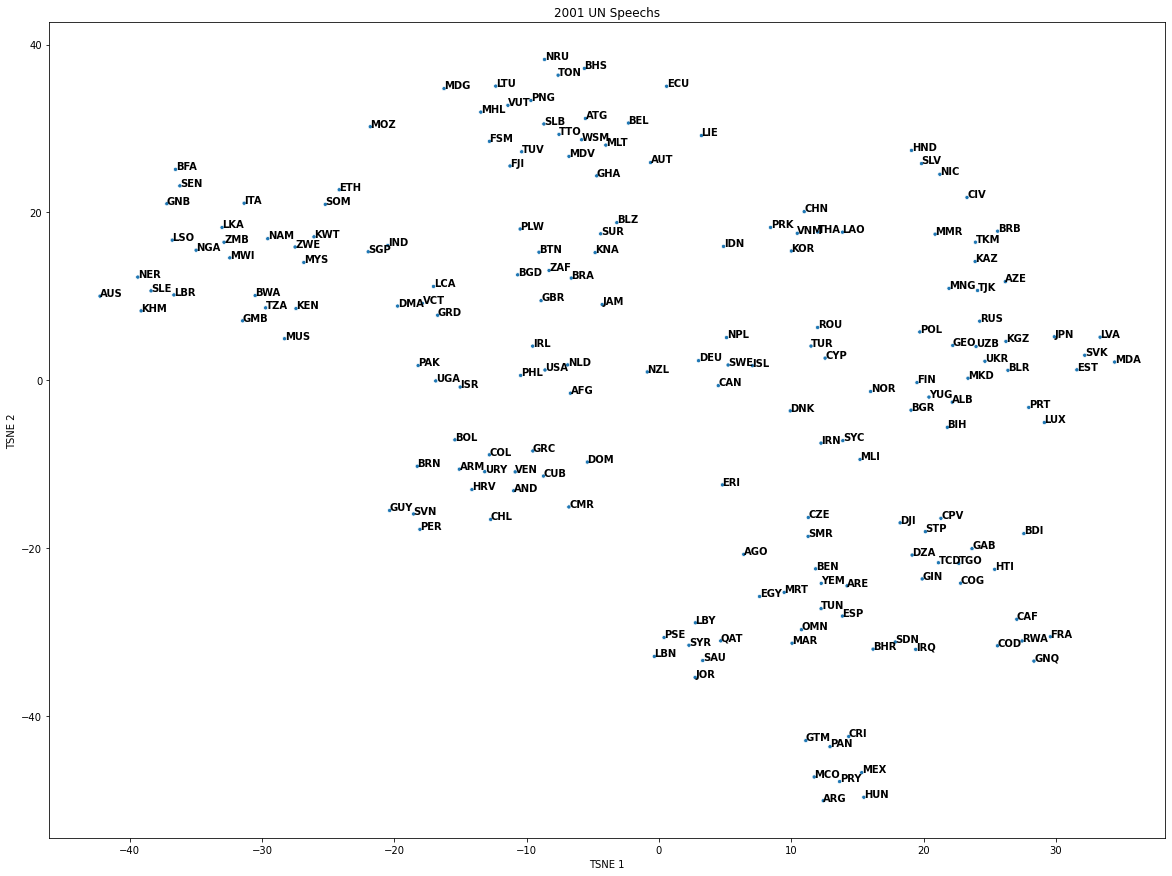

In [42]:
plt.figure(figsize=(20,15))
scatter_text('dim1', 'dim2', 'country_code',
             data = viz, 
             title = '2001 UN Speechs', 
             xlabel = 'TSNE 1',
             ylabel = 'TSNE 2')

In [43]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
speech19[['ISO Code','Country']].head(200)

ISO Code                           Country
4637      AFG                       Afghanistan
4638      AGO                            Angola
4639      ALB                           Albania
4640      AND                           Andorra
4641      ARE                               UAE
4642      ARG                         Argentina
4643      ARM                           Armenia
4644      ATG               Antigua and Barbuda
4645      AUS                         Australia
4646      AUT                           Austria
4647      AZE                        Azerbaijan
4648      BDI                           Burundi
4649      BEL                           Belgium
4650      BEN                             Benin
4651      BFA                      Burkina Faso
4652      BGD                        Bangladesh
4653      BGR                          Bulgaria
4654      BHR                           Bahrain
4655      BHS                           Bahamas
4656      BIH            Bosnia and Herzegovina
4657      BLR                           Belarus
4658      BLZ                            Belize
4659      BOL                           Bolivia
4660      BRA                            Brazil
4661      BRB                          Barbados
4662      BRN                            Brunei
4663      BTN                            Bhutan
4664      BWA                          Botswana
4665      CAF                               CAR
4666      CAN                            Canada
4667      CHL                             Chile
4668      CHN                             China
4669      CIV                     Cote d'Ivoire
4670      CMR                          Cameroon
4671      COD                               DRC
4672      COG                             Congo
4673      COL                          Colombia
4675      CPV                        Cape Verde
4676      CRI                        Costa Rica
4677      CUB                              Cuba
4678      CYP                            Cyprus
4679      CZE                    Czech Republic
4680      DEU                           Germany
4681      DJI                          Djibouti
4682      DMA                          Dominica
4683      DNK                           Denmark
4684      DOM                Dominican Republic
4685      DZA                           Algeria
4686      ECU                           Ecuador
4687      EGY                             Egypt
4688      ERI                           Eritrea
4689      ESP                             Spain
4690      EST                           Estonia
4691      ETH                          Ethiopia
4692      FIN                           Finland
4693      FJI                              Fiji
4694      FRA                            France
4695      FSM    Federated States of Micronesia
4696      GAB                             Gabon
4697      GBR                    United Kingdom
4698      GEO                           Georgia
4699      GHA                             Ghana
4700      GIN                            Guinea
4701      GMB                            Gambia
4702      GNB                     Guinea-Bissau
4703      GNQ                 Equatorial Guinea
4704      GRC                            Greece
4705      GRD                           Grenada
4706      GTM                         Guatemala
4707      GUY                            Guyana
4708      HND                          Honduras
4709      HRV                           Croatia
4710      HTI                             Haiti
4711      HUN                           Hungary
4712      IDN                         Indonesia
4713      IND                             India
4714      IRL                           Ireland
4715      IRN                              Iran
4716      IRQ                              Iraq
4717      ISL                           Iceland
4718      ISR                            Israel
4719      ITA                             Italy
4720      JAM        

In [44]:
import plotly.express as px

In [45]:
fig = px.scatter(viz, x="dim1", y="dim2",color="country",
                  hover_data=['country_code','country'],title="2001 UNGA speeches_without_GPE",text="country_code",width=1700,height=1200)
fig.show()

In [46]:
fig.write_html("speechs_2001_Without_GPE_new.html")

In [47]:
import scipy.cluster.hierarchy as hac 

In [48]:
z = hac.linkage(viz[['dim1','dim2']], method='complete') 
labels = hac.fcluster(z, 1, criterion="distance")
labels = hac.fcluster(z, 30, criterion="distance")

In [49]:
labels

array([ 8,  2,  5,  7,  2,  1,  7,  9, 10,  9,  6,  3,  9,  2, 10,  8,  5,
        1,  9,  5,  5,  8,  7,  8,  6,  7,  8, 10,  3,  4,  7,  6,  6,  7,
        3,  3,  7,  3,  1,  7,  4,  2,  4,  3,  8,  4,  7,  3,  9,  2,  2,
        1,  5, 10,  5,  9,  3,  9,  3,  8,  5,  9,  3, 10, 10,  3,  7,  8,
        1,  7,  6,  7,  3,  1,  6, 10,  8,  4,  1,  4,  8, 10,  8,  1,  5,
        6, 10,  5, 10,  8,  6, 10,  6,  1, 10,  1,  8,  9, 10, 10,  9,  5,
        5,  1,  1,  5,  9,  9,  1,  9,  5,  4,  9,  6,  6, 10,  2, 10, 10,
       10, 10, 10, 10,  6,  8,  4,  4,  9,  4,  1,  8,  1,  7,  8,  8,  9,
        5,  6,  5,  1,  1,  1,  4,  5,  3,  1,  1, 10, 10,  9, 10,  6,  2,
       10,  3,  8,  5,  7,  4,  4,  1,  3,  3,  6,  6,  6,  9,  9,  1,  4,
        9, 10,  8,  5,  7,  8,  5,  8,  7,  6,  9,  9,  2,  5,  8, 10, 10],
      dtype=int32)

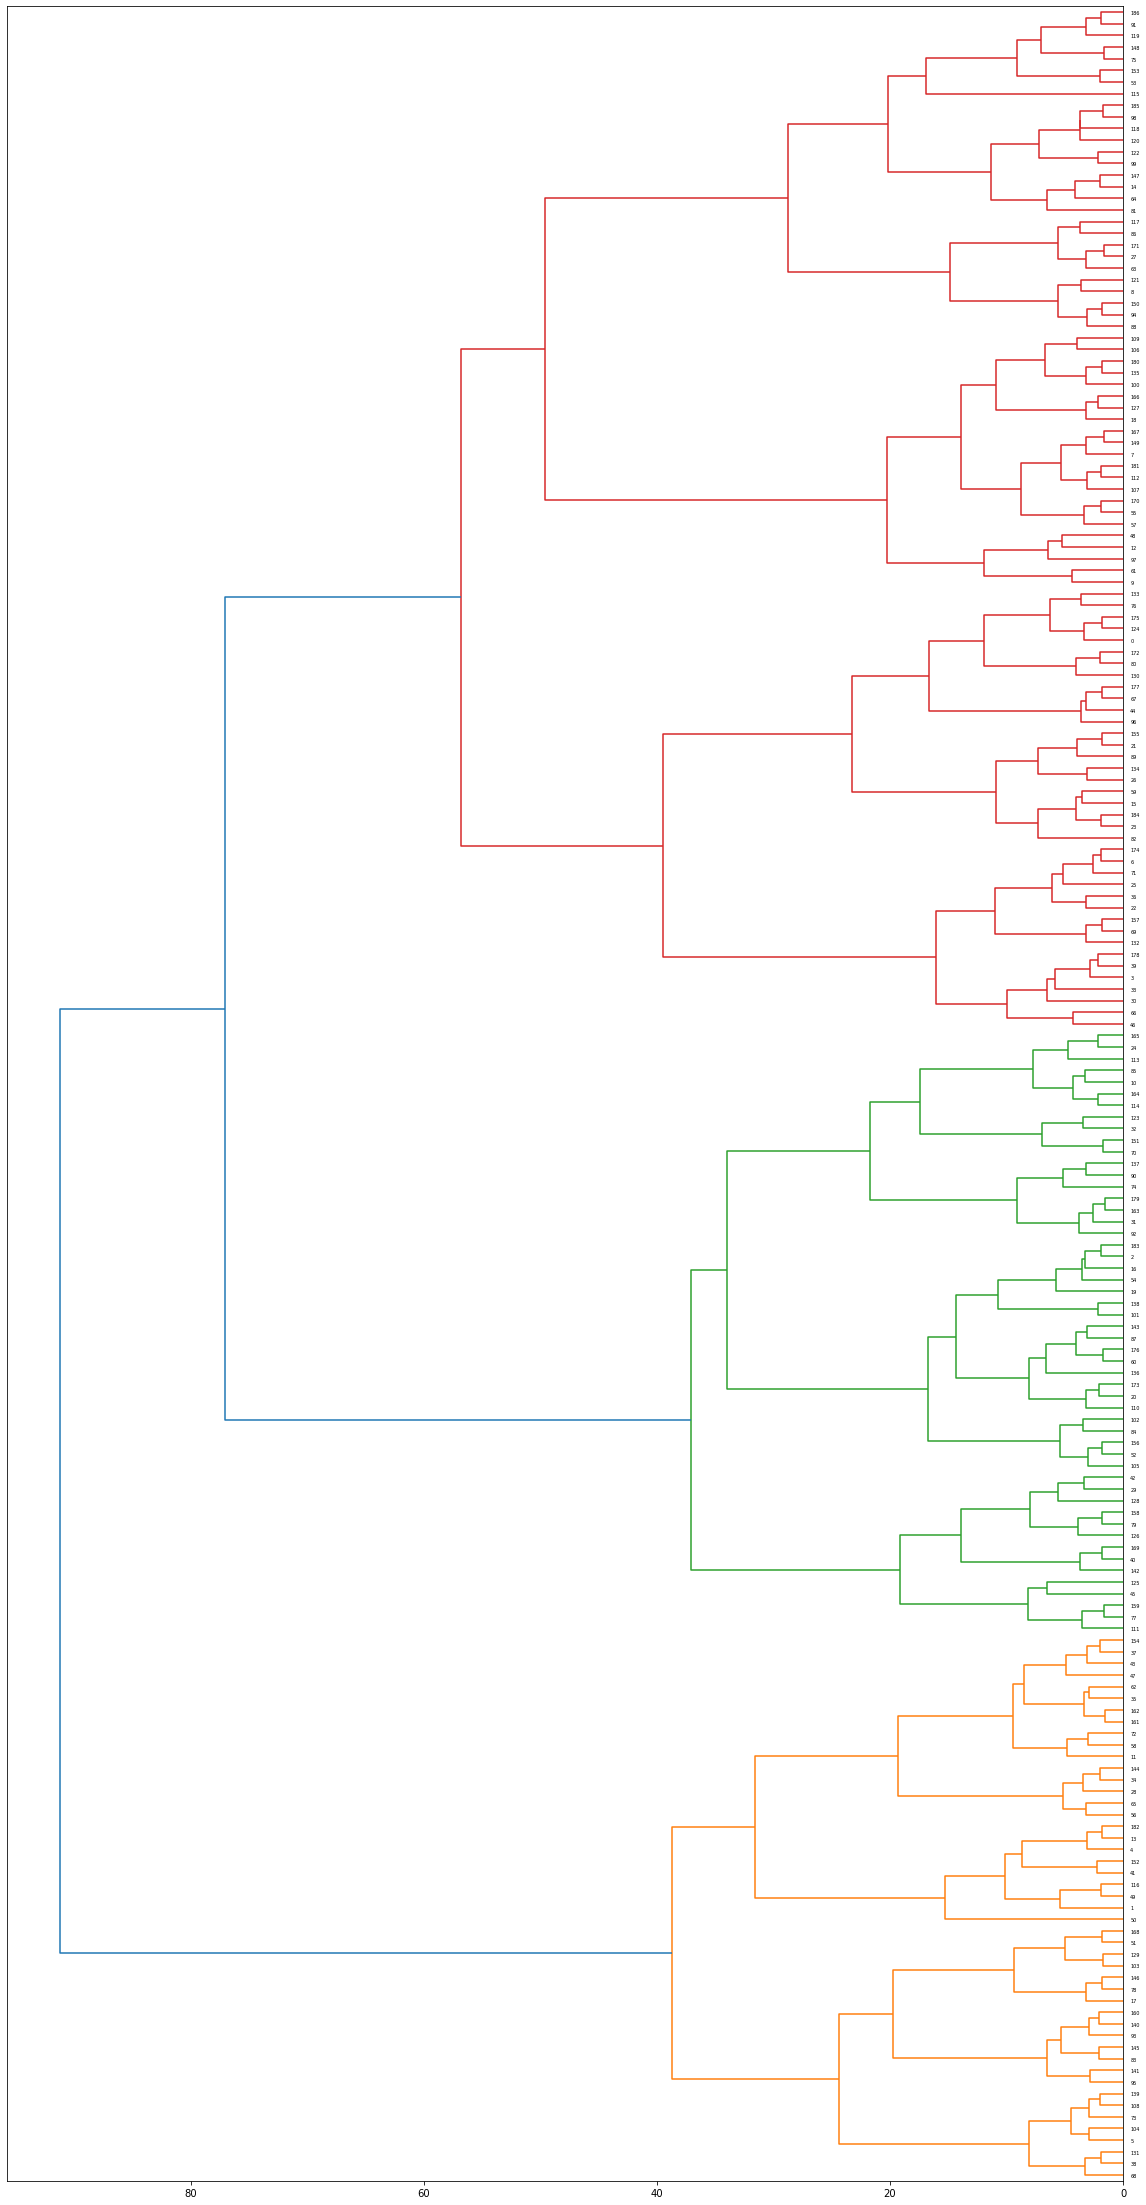

In [50]:
plt.figure(figsize=(20,40))
h=hac.dendrogram(z,orientation='left')
plt.show()

In [51]:
viz['labels']=["CLUSTER "+str(i) if i!=-1  else "Outlier or Noise" for i in labels ]

In [52]:
fig = px.scatter(viz, x="dim1", y="dim2",color="labels",
                  hover_data=['country_code','country'],title="2001 UNGA speeches without GPE hierarchy clustering",text="country_code",width=1700,height=1200)
fig.show()

In [53]:
fig.write_html("speechs_2001_Without_GPE_new_labels_dendogram.html")

In [54]:
from sklearn.cluster import KMeans

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.



Text(0, 0.5, 'Inertia')

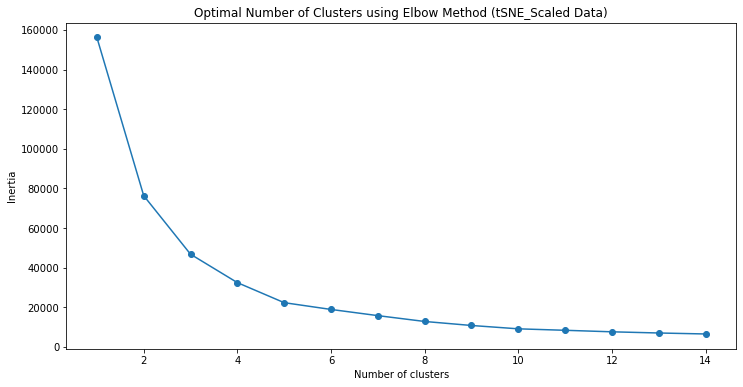

In [55]:
sse = []
k_list = range(1, 15)
for k in k_list:
    km = KMeans(n_clusters=k)
    km.fit(viz[['dim1','dim2']])
    sse.append([k, km.inertia_])
    
tsne_results_scale = pd.DataFrame({'Cluster': range(1,15), 'SSE': sse})
plt.figure(figsize=(12,6))
plt.plot(pd.DataFrame(sse)[0], pd.DataFrame(sse)[1], marker='o')
plt.title('Optimal Number of Clusters using Elbow Method (tSNE_Scaled Data)')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

In [56]:
viz

dim1       dim2 country_code                           country      labels
0    -6.691699  -1.553910          AFG                       Afghanistan   CLUSTER 8
1     6.412123 -20.763063          AGO                            Angola   CLUSTER 2
2    22.171467  -2.621833          ALB                           Albania   CLUSTER 5
3   -10.979773 -13.180923          AND                           Andorra   CLUSTER 7
4    14.221209 -24.511753          ARE                               UAE   CLUSTER 2
5    12.418900 -50.128197          ARG                         Argentina   CLUSTER 1
6   -15.086343 -10.610900          ARM                           Armenia   CLUSTER 7
7    -5.554595  31.189741          ATG               Antigua and Barbuda   CLUSTER 9
8   -42.240517  10.012239          AUS                         Australia  CLUSTER 10
9    -0.630335  25.933317          AUT                           Austria   CLUSTER 9
10   26.178225  11.735147          AZE                        Azerbaijan   CLUSTER 6
11   27.582640 -18.288204          BDI                           Burundi   CLUSTER 3
12   -2.302570  30.645630          BEL                           Belgium   CLUSTER 9
13   11.842119 -22.486866          BEN                             Benin   CLUSTER 2
14  -36.537479  25.124311          BFA                      Burkina Faso  CLUSTER 10
15  -10.677341  12.555031          BGD                        Bangladesh   CLUSTER 8
16   19.054434  -3.576112          BGR                          Bulgaria   CLUSTER 5
17   16.186850 -32.059471          BHR                           Bahrain   CLUSTER 1
18   -5.633342  37.156914          BHS                           Bahamas   CLUSTER 9
19   21.799999  -5.617625          BIH            Bosnia and Herzegovina   CLUSTER 5
20   26.379314   1.173583          BLR                           Belarus   CLUSTER 5
21   -3.181758  18.775049          BLZ                            Belize   CLUSTER 8
22  -15.419926  -7.109944          BOL                           Bolivia   CLUSTER 7
23   -6.624406  12.167786          BRA                            Brazil   CLUSTER 8
24   25.599634  17.755556          BRB                          Barbados   CLUSTER 6
25  -18.264519 -10.260304          BRN                            Brunei   CLUSTER 7
26   -9.065992  15.249507          BTN                            Bhutan   CLUSTER 8
27  -30.517538  10.087602          BWA                          Botswana  CLUSTER 10
28   27.048496 -28.499733          CAF                               CAR   CLUSTER 3
29    4.485971  -0.653507          CAN                            Canada   CLUSTER 4
30  -12.716207 -16.600557          CHL                             Chile   CLUSTER 7
31   10.980053  20.084845          CHN                             China   CLUSTER 6
32   23.285006  21.777567          CIV                     Cote d'Ivoire   CLUSTER 6
33   -6.806552 -15.111084          CMR                          Cameroon   CLUSTER 7
34   25.589598 -31.660858          COD                               DRC   CLUSTER 3
35   22.799213 -24.198727          COG                             Congo   CLUSTER 3
36  -12.816088  -8.898683          COL                          Colombia   CLUSTER 7
37   21.314960 -16.466700          CPV                        Cape Verde   CLUSTER 3
38   14.348474 -42.470284          CRI                        Costa Rica   CLUSTER 1
39   -8.727380 -11.430673          CUB                              Cuba   CLUSTER 7
40   12.560323   2.624507          CYP                            Cyprus   CLUSTER 4
41   11.289804 -16.366058          CZE                    Czech Republic   CLUSTER 2
42    2.995358   2.320524          DEU                           Germany   CLUSTER 4
43   18.229910 -17.004507          DJI                          Djibouti   CLUSTER 3
44  -19.754063   8.830580          DMA                          Dominica   CLUSTER 8
45    9.926675  -3.662468          DNK                           Denmark   CLUSTER 4
46   -5.408677 

In [57]:
kmeans = KMeans(n_clusters=6, random_state=0).fit(viz[['dim1','dim2']])
kmeans.labels_

labels=kmeans.predict(viz[['dim1','dim2']])
viz['labels']=["CLUSTER "+str(i) if i!=-1  else "Outlier or Noise" for i in labels ]

In [58]:

fig = px.scatter(viz, x="dim1", y="dim2",color="labels",
                  hover_data=['country_code','country'],title="2011 UNGA speeches_without GPE KMEANS CLUSTERS",text="country_code",width=1700,height=1200)
fig.show()

In [59]:
fig.write_html("speechs_2001_Without_GPE_new_labels_kmeans.html")

In [60]:
from sklearn.cluster import DBSCAN
import numpy as np

clustering = DBSCAN(eps=5.5, min_samples=6).fit(viz[['dim1','dim2']])
labels=clustering.labels_

In [61]:
set(labels)

{-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}

In [62]:

viz['labels']=["CLUSTER "+str(i) if i!=-1  else "Outlier or Noise" for i in labels ]

In [63]:
fig = px.scatter(viz, x="dim1", y="dim2",color="labels",
                  hover_data=['country_code','country'],title="2011 UNGA speeches without GPE DBSCAN",text="country_code",width=1700,height=1200)
fig.show()

In [64]:
fig.write_html("speechs_2001_Without_GPE_new_labels1.html")

In [65]:
df.columns

Index(['doc', 'Year', 'Session', 'ISO Code', 'Country', 'Name of Person Speaking', 'Post', 'Language', 'Notes', 'sent_split', 'word_split', 'count_speech_words', 'count_speech_sent'], dtype='object')

In [66]:
speech19['labels']=viz['labels'].values

<ipython-input-66-8f92495e96f9>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [67]:
speech19.shape

(187, 15)

In [68]:
speech19.to_json("un_speeches_2001_labels.json",orient='records',compression='infer')